<a href="https://colab.research.google.com/github/JoeJoe1313/Recommender-Systems/blob/master/Copy_of_Content_based_Recommender_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Intro

#Imports

In [1]:
import matplotlib.pyplot as plt
import nltk
import pandas as pd
import scipy
import sklearn
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

#Data


## Data Downloading


In [2]:
!gsutil cp -r gs://rec-sys-fmi/hw2-dataset .
!ls .

Copying gs://rec-sys-fmi/hw2-dataset/shared_articles.csv...
Copying gs://rec-sys-fmi/hw2-dataset/users_interactions.csv...
/ [2 files][ 28.6 MiB/ 28.6 MiB]                                                
Operation completed over 2 objects/28.6 MiB.                                     
hw2-dataset  sample_data


##EDA

In [3]:
interactions_df = pd.read_csv('hw2-dataset/users_interactions.csv')
articles_df = pd.read_csv('hw2-dataset/shared_articles.csv')

###user interactions EDA and cleaning


In [4]:
interactions_df.shape

(72312, 8)

In [5]:
interactions_df[:2]

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US


In [6]:
interactions_df.isna().value_counts()

timestamp  eventType  contentId  personId  sessionId  userAgent  userRegion  userCountry
False      False      False      False     False      False      False       False          56907
                                                      True       True        True           15394
                                                      False      True        False             11
dtype: int64

In [7]:
#number of distinct users
distinct_users = interactions_df['personId'].value_counts() # interactions per user
len(distinct_users)

1895

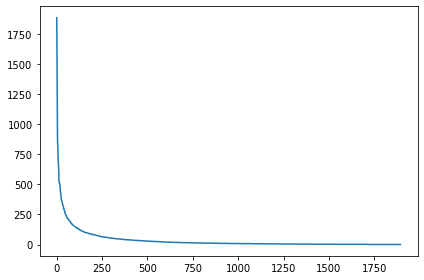

In [8]:
# interactions per user
plt.plot(distinct_users.values) 
plt.tight_layout()
plt.show()

In [9]:
interactions_df = interactions_df[['contentId', 'personId', 'eventType']]
interactions_df

,contentId,personId,eventType
0,-3499919498720038879,-8845298781299428018,VIEW
1,8890720798209849691,-1032019229384696495,VIEW
2,310515487419366995,-1130272294246983140,VIEW
3,310515487419366995,344280948527967603,FOLLOW
4,-7820640624231356730,-445337111692715325,VIEW
...,...,...,...
72307,-6590819806697898649,-9016528795238256703,LIKE
72308,-5813211845057621660,102305705598210278,VIEW
72309,-1999468346928419252,-9196668942822132778,VIEW
72310,-6590819806697898649,-9016528795238256703,VIEW


In [10]:
interactions_df['eventType'].value_counts()

VIEW               61086
LIKE                5745
BOOKMARK            2463
COMMENT CREATED     1611
FOLLOW              1407
Name: eventType, dtype: int64

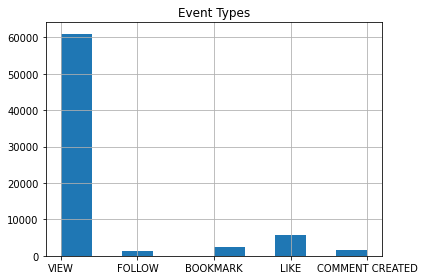

In [11]:
interactions_df['eventType'].hist()
plt.title('Event Types')
plt.tight_layout()
plt.show()

In [12]:
# will leave only one record for user content, as in order to combine the diffent events will score them - view is implicit preference so 1 point, 
# like/comment/bookmark/follow are explicit/implicit preferences that probably the user like it so 5 points. after that will 
# aggragete with leaving the highest score, so if user viewed,liked and comment the score will still be 5(not higher)

# use different values for the events 
di = {
    'VIEW': 1.0, 
    'LIKE': 2.0,
    'BOOKMARK': 2.5,
    'COMMENT CREATED': 4.0,
    'FOLLOW': 3.0
} 
interactions_df['prefScore'] = interactions_df['eventType'].map(di)

# change the min prefScore due to changed event type values 
# use such a number that a similar number of people are filtered 
MIN_PREF_SCORE = 23.5

In [13]:
interactions_df = interactions_df.groupby(['contentId', 'personId']).max().reset_index()
interactions_df

,contentId,personId,eventType,prefScore
0,-9222795471790223670,-6944500707172804068,LIKE,2.0
1,-9222795471790223670,-5868110530814399805,VIEW,3.0
2,-9222795471790223670,-1032019229384696495,VIEW,4.0
3,-9222795471790223670,1895326251577378793,VIEW,4.0
4,-9222795471790223670,8968131284214320024,VIEW,2.0
...,...,...,...,...
40705,9222265156747237864,-7540738139248278851,VIEW,1.0
40706,9222265156747237864,-3596626804281480007,VIEW,1.0
40707,9222265156747237864,692689608292948411,VIEW,1.0
40708,9222265156747237864,2873028073541627603,VIEW,1.0


In [14]:
# for the cold start problem
# lets drop all the users for which we don't have at least 5*6 scores (5 explicit prefenrences or correspondant number of implicit ones)
interactions_count_df = interactions_df.groupby('personId').sum('prefScore')
enough_interactions_df = interactions_count_df[interactions_count_df['prefScore'] >= MIN_PREF_SCORE].reset_index()[['personId', 'prefScore']]
enough_interactions_df

,personId,prefScore
0,-9223121837663643404,44.0
1,-9172914609055320039,24.0
2,-9120685872592674274,50.0
3,-9109785559521267180,43.0
4,-9047547311469006438,25.5
...,...,...
468,8920667914865172372,33.5
469,8968131284214320024,195.5
470,9109075639526981934,103.0
471,9148269800512008413,87.5


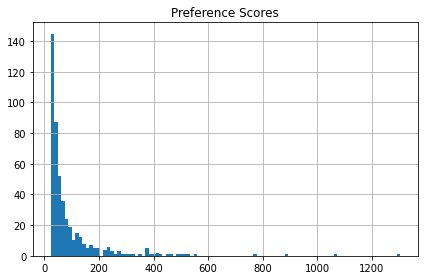

In [15]:
enough_interactions_df['prefScore'].hist(bins=100)
plt.title('Preference Scores')
plt.tight_layout()
plt.show()

In [16]:
interactions_from_selected_users_df = interactions_df.merge(
    enough_interactions_df[['personId']], 
    how='right',
    left_on='personId',
    right_on='personId'
)
interactions_from_selected_users_df.shape

(32538, 4)

In [17]:
interactions_from_selected_users_df

,contentId,personId,eventType,prefScore
0,-8949113594875411859,-9223121837663643404,VIEW,1.0
1,-8377626164558006982,-9223121837663643404,VIEW,1.0
2,-8208801367848627943,-9223121837663643404,VIEW,1.0
3,-8187220755213888616,-9223121837663643404,VIEW,1.0
4,-7423191370472335463,-9223121837663643404,VIEW,1.0
...,...,...,...,...
32533,8477804012624580461,9210530975708218054,VIEW,3.0
32534,8526042588044002101,9210530975708218054,VIEW,1.0
32535,8856169137131817223,9210530975708218054,VIEW,1.0
32536,8869347744613364434,9210530975708218054,VIEW,1.0


###arcticles EDA and cleaning

In [18]:
articles_df.shape

(3122, 13)

In [19]:
articles_df[:2]

,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
0,1459192779,CONTENT REMOVED,-6451309518266745024,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en


In [20]:
articles_df.isna().value_counts()

timestamp  eventType  contentId  authorPersonId  authorSessionId  authorUserAgent  authorRegion  authorCountry  contentType  url    title  text   lang 
False      False      False      False           False            True             True          True           False        False  False  False  False    2442
                                                                  False            False         False          False        False  False  False  False     680
dtype: int64

In [21]:
articles_df['lang'].value_counts()

en    2264
pt     850
la       4
ja       2
es       2
Name: lang, dtype: int64

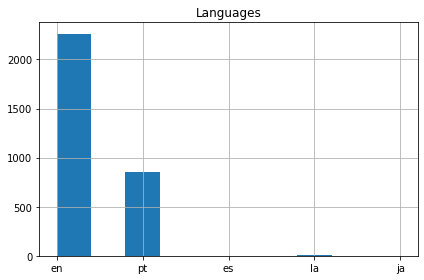

In [22]:
articles_df['lang'].hist()
plt.title('Languages')
plt.tight_layout()
plt.show()

For our case of demonstrating content based filtering we are interested only in the PersonId-ContentId-Action information + the title and text of the Contents as we will left only english texts.

In [23]:
articles_df = articles_df[articles_df['lang'] == 'en']
articles_df = articles_df[['contentId', 'title', 'text']]
articles_df[0:2]

,contentId,title,text
0,-6451309518266745024,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...
1,-4110354420726924665,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...


In [24]:
# leave only unique contentIds
articles_df = articles_df.drop_duplicates('contentId')
articles_df.shape

(2218, 3)

###Final Cleaning


In [25]:
print(f'Interactions from selected users: {interactions_from_selected_users_df.shape}')
final_interactions = interactions_from_selected_users_df.merge(
    articles_df, 
    how='right',
    left_on='contentId',
    right_on='contentId'
)
print(f'Final interactions: {final_interactions.shape}')

Interactions from selected users: (32538, 4)
Final interactions: (21966, 6)


In [26]:
interactions_from_selected_users_df['personId'].value_counts()

 3609194402293569455    961
-2626634673110551643    669
-1032019229384696495    648
-1443636648652872475    585
-2979881261169775358    437
                       ... 
 5404470824348262768     15
-8532959362941292070     14
 8437083040455072898     14
-4293690759387208926     14
 3007736603136734729     14
Name: personId, Length: 473, dtype: int64

In [27]:
final_interactions_count_df = final_interactions.groupby('personId').sum().reset_index()[['personId', 'prefScore']]
final_interactions_count_df = final_interactions_count_df[final_interactions_count_df['prefScore'] >= MIN_PREF_SCORE]
final_users_with_enough_interactions_df = final_interactions_count_df[final_interactions_count_df['prefScore'] >= MIN_PREF_SCORE]

print(f'Users after filtering: {final_users_with_enough_interactions_df.shape[0]}')
print(f'Interactions after filtering: {final_interactions_count_df.shape[0]}')

Users after filtering: 312
Interactions after filtering: 312


In [28]:
final_interactions = final_interactions.merge(
    final_users_with_enough_interactions_df[['personId']], 
    how='right',
    left_on='personId',
    right_on='personId'
)
print(f'Interactions after final filtering: {final_interactions.shape[0]}')

Interactions after final filtering: 19832


In [29]:
interactions_train_df, interactions_test_df = train_test_split(
    final_interactions,
    stratify=final_interactions['personId'], 
    test_size=0.30,
    random_state=13
)

print(f'Interactions on Train set: {len(interactions_train_df)}')
print(f'Interactions on Test set: {len(interactions_test_df)}')

Interactions on Train set: 13882
Interactions on Test set: 5950


#Content Based Recommender


In [30]:
# train set is at interactions_train_df 
# test set is at interactions_test_df

In [31]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [32]:
# some text preprocessing 
# lowercase and stem all of the words in order to reduce the number of unique tokens 
# this is important because the total size of the text is not big 
stemmer = nltk.stem.PorterStemmer()
data = (articles_df['title'] + " " + articles_df['text']).str.lower().values 
tokenized = [nltk.tokenize.word_tokenize(text) for text in data]
stemmed = [' '.join([stemmer.stem(word) for word in text]) for text in tokenized]

In [33]:
stopwords_list = stopwords.words('english')
# make sure that the stemmed stop words are still ignored 
stopwords_list = stopwords_list + [stemmer.stem(word) for word in stopwords_list]

# some changes in the TfidfVectorizer parameters 
# it seems like common words degrade performance 
vectorizer = TfidfVectorizer(
    analyzer='word',
    ngram_range=(1, 2),
    min_df=0.005,
    max_df=0.05,
    max_features=1000,
    stop_words=stopwords_list
)

item_ids = articles_df['contentId'].tolist()
tfidf_matrix = vectorizer.fit_transform(stemmed)
tfidf_feature_names = vectorizer.get_feature_names()

In [34]:
print(tfidf_matrix.shape)
print(tfidf_feature_names)

(2218, 1000)
['10 year', '17', '19', '2010', '2011', '2017', '21', '22', '32', '3d', '45', '70', 'abstract', 'accomplish', 'accuraci', 'acknowledg', 'acquia', 'admin', 'administr', 'adob', 'afford', 'agenc', 'agent', 'aggreg', 'agil', 'agil team', 'agreement', 'air', 'airbnb', 'al', 'alert', 'alexa', 'align', 'alloc', 'allow user', 'alphabet', 'alter', 'america', 'amp', 'analyst', 'android studio', 'angular', 'anim', 'annot', 'anonym', 'answer question', 'anticip', 'anymor', 'anyway', 'apach', 'apart', 'app engin', 'app store', 'app use', 'appar', 'appeal', 'appreci', 'approv', 'approxim', 'april', 'architect', 'archiv', 'argument', 'arm', 'artifact', 'artist', 'asid', 'assembl', 'assert', 'assess', 'assumpt', 'async', 'asynchron', 'atom', 'attach', 'attack', 'attend', 'audio', 'audit', 'augment', 'authent', 'autonom', 'aw', 'award', 'awesom', 'azur', 'back end', 'backend', 'backup', 'bar', 'barrier', 'bash', 'batch', 'batteri', 'beat', 'beauti', 'behav', 'benchmark', 'best practic', '

## Build User Profiles
The profiles are build from all the content which the user engaded with with taken the scores in consideration

In [35]:
# calculate user profiles from train dataset
user_profiles = {}
for person_id in interactions_train_df['personId'].unique():
  user_profile = None
  interactions_person_df = interactions_train_df[interactions_train_df['personId'] == person_id]
  all_scores = interactions_person_df['prefScore'].sum()
  for index, row in interactions_person_df.iterrows():
    content_id = row['contentId']
    score = row['prefScore']
    if(user_profile==None):
      user_profile = tfidf_matrix[item_ids.index(content_id)] * score / all_scores
    else:
      user_profile = scipy.sparse.vstack((user_profile, tfidf_matrix[item_ids.index(content_id)] * score / all_scores))
  user_profiles[person_id] = user_profile

### Evaluate

In [36]:
#recommend items to the users from the test dataset 
#Evaluation is with MRR (https://en.wikipedia.org/wiki/Mean_reciprocal_rank)

In [37]:
mrr = 0
for person_id in interactions_train_df['personId'].unique():
  cosine_similarities = cosine_similarity(user_profiles[person_id], tfidf_matrix)
  # summing columnwise 
  # this way we get for each content how close it is to all of the contents that are interesting for a specific person 
  similar_indices = cosine_similarities.sum(axis=0).argsort()[::-1]
  items_to_ignore = interactions_train_df[interactions_train_df['personId'] == person_id]['contentId'].values
  items_to_evaluate = interactions_test_df[interactions_test_df['personId'] == person_id]['contentId'].values
  similar_indices_filtered = list(filter(lambda x: item_ids[x] not in items_to_ignore, similar_indices))
  # print('After filtering train set items for person ', person_id, ' = ',len(similar_indices_filtered))
  
  first_rank = len(similar_indices_filtered);
  l = len(similar_indices_filtered);
  for i in range(l):
    if(item_ids[similar_indices_filtered[i]] in items_to_evaluate):
      first_rank = i+1;
      break;
  mrr += 1 / first_rank
  # print('first rank = ', first_rank);
  # print('number of train items = ', len(items_to_ignore))
mrr /= interactions_train_df.personId.nunique()

In [38]:
print('mrr = ', mrr)

mrr =  0.2078989317676395
